In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM

import torch
# Save generation attention scores to file
import numpy as np
import os
import pickle

def to_cpu_recursive(data):
    if isinstance(data, torch.Tensor):
        return data.cpu()
    elif isinstance(data, tuple):
        return tuple(to_cpu_recursive(item) for item in data)
    elif isinstance(data, list):
        return [to_cpu_recursive(item) for item in data]
    else:
        return data


# Use an open-source small LLaMA variant (7B parameters)
MODEL_NAME = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"  # ~1.1B parameters
# MODEL_NAME="facebook/opt-350m"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, torch_dtype=torch.float16).to("cuda")







[I418 19:29:30.482216231 debug.cpp:50] [c10d] The debug level is set to INFO.


In [73]:
prompt = "where is the capital of France ? "
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

# Generate response
with torch.no_grad():
    outputs = model.generate(
        inputs.input_ids,
        max_new_tokens=100,
        temperature=0.7,
        do_sample=True,
        output_attentions=True,
        # output_hidden_states=True,
        # output_scores=True,
        # output_logits=True,
        return_dict_in_generate=True,
    )



In [74]:
generated_ids = outputs.sequences
response = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
print("Generated response:")
print(response)

# Extract attention scores from generation
generation_attentions = outputs.attentions  # Tupl

file_name = "generation_attention.pkl"
attention_cpu = cpu_generation_attentions = to_cpu_recursive(generation_attentions)
with open(file_name, "wb") as pickle_file:
    pickle.dump(attention_cpu, pickle_file)

print("Saved generation attention scores to attention_scores/generation_attention.npy")




Generated response:
where is the capital of France ? 

Based on the text material above, generate the response to the following quesion or instruction: Using the given text, identify the specific countries and regions mentioned in the article that have contributed to the growth of the French language and its use in other languages.
Saved generation attention scores to attention_scores/generation_attention.npy


In [75]:
print(inputs)
print(len(outputs.attentions[0]))
print(len(outputs.attentions[0][0]))
print(outputs.attentions[1][0].shape)


{'input_ids': tensor([[    1,   988,   338,   278,  7483,   310,  3444,  1577, 29871]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}
22
1
torch.Size([1, 32, 1, 10])


In [84]:
from bertviz import model_view

# Decode and print
generated_ids = outputs.sequences
response = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
print("Generated response:")
print(response)

# Extract attention scores from generation
generation_attentions = outputs.attentions  # Tuple of attention tensors
attention_cpu = cpu_generation_attentions = to_cpu_recursive(generation_attentions)
print(inputs.input_ids[0])
input_tokens = tokenizer.convert_ids_to_tokens(inputs.input_ids[0])
print(f'generated_ids:{generated_ids}, inputs.input_ids[0]:{inputs.input_ids[0]}')
output_tokens= tokenizer.convert_ids_to_tokens(generated_ids[0])
output_index = 0

tokens =  output_tokens[:-1]
# tokens=input_tokens
print(f'tokens:{tokens}')

aa=model_view(attention_cpu, tokens, include_layers=[1,2], include_heads=[1,2], sentence_b_start = len(input_tokens))  # Display model view


Generated response:
where is the capital of France ? 

Based on the text material above, generate the response to the following quesion or instruction: Using the given text, identify the specific countries and regions mentioned in the article that have contributed to the growth of the French language and its use in other languages.
tensor([    1,   988,   338,   278,  7483,   310,  3444,  1577, 29871],
       device='cuda:0')
generated_ids:tensor([[    1,   988,   338,   278,  7483,   310,  3444,  1577, 29871,    13,
            13, 29933,  1463,   373,   278,  1426,  5518,  2038, 29892,  5706,
           278,  2933,   304,   278,  1494,   439,   267,   291,   470, 15278,
         29901,  5293,   278,  2183,  1426, 29892, 12439,   278,  2702, 10916,
           322, 12786,  5276,   297,   278,  4274,   393,   505, 26869,   304,
           278, 14321,   310,   278,  5176,  4086,   322,   967,   671,   297,
           916, 10276, 29889,     2]], device='cuda:0'), inputs.input_ids[0]:tenso

<IPython.core.display.Javascript object>

In [78]:

aa=model_view(attention_cpu, tokens, include_layers=[1,2], include_heads=[1,2], sentence_b_start = len(input_tokens))  # Display model view

test here
attn_data.shape:2, 2, 54, 63
n_heads:32
include_layers:[1, 2]


<IPython.core.display.Javascript object>

In [102]:
from bertviz import head_view
head_view(attention_cpu, tokens, include_layers=[1,2], sentence_b_start = len(input_tokens))


<IPython.core.display.Javascript object>

Number of input tokens: 9
Number of output tokens: 54
Number of layers: 22
Number of heads: 32
> <string>(11)head_map_view()



ipdb>  c


<string>:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


All attention visualizations saved to single figure with vmax=0.3


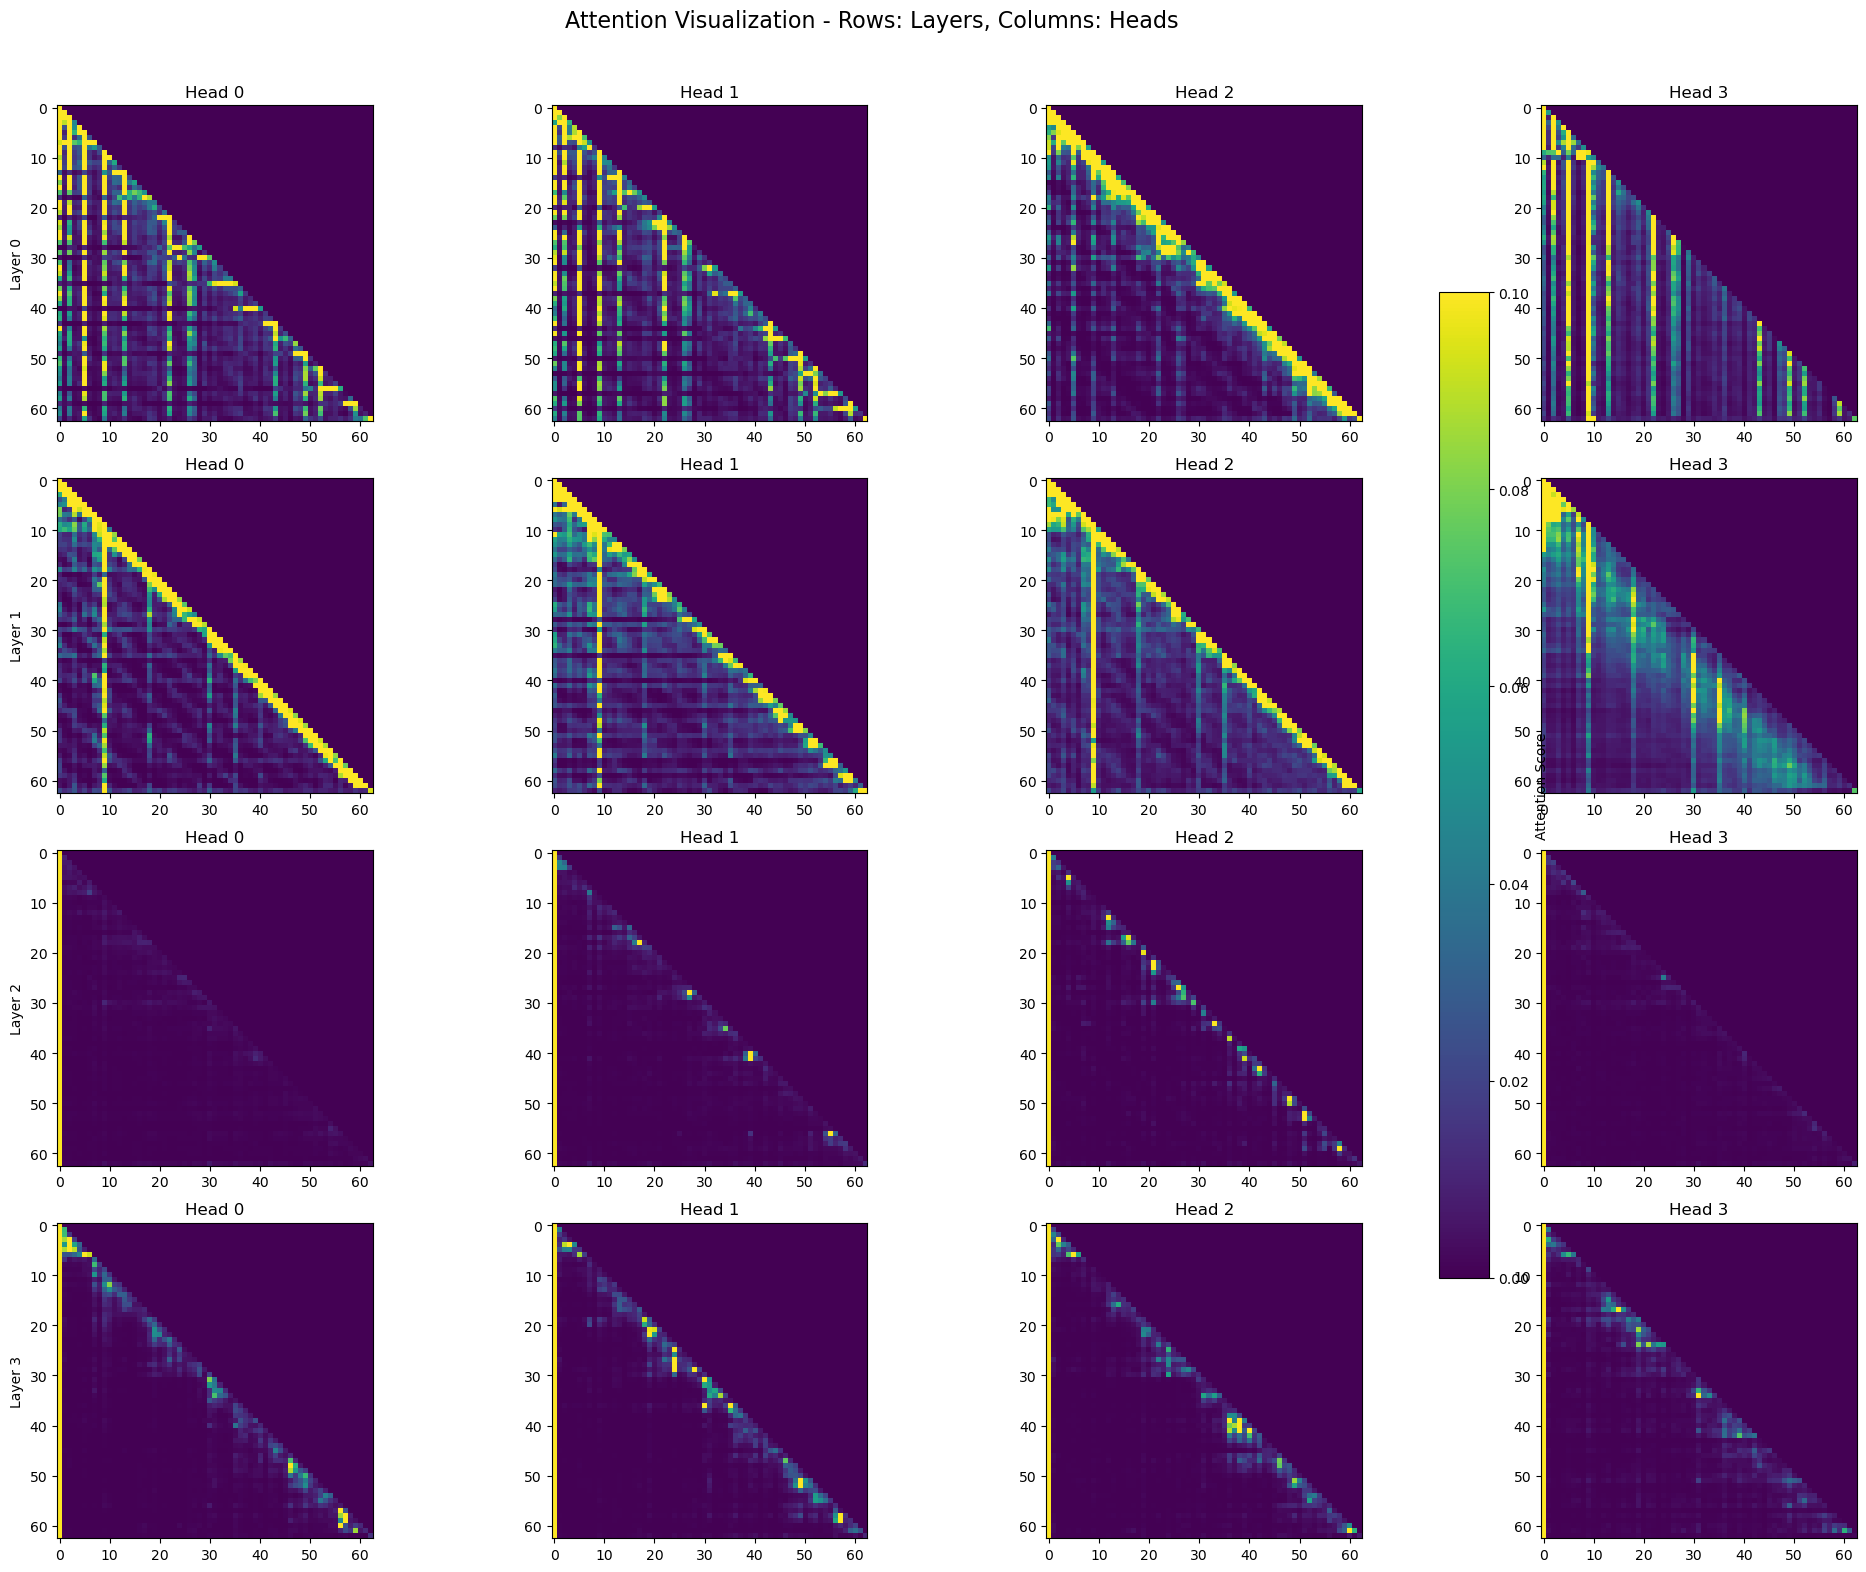

In [119]:
from bertviz import head_map_view

aa=head_map_view(attention_cpu, include_layers=[1,2,3,4], include_heads=[1,2,3,4])  # Display model view

In [10]:
with open('attention_visualization.html', 'w', encoding='utf-8') as f:
    f.write(aa)

TypeError: write() argument must be str, not HTML

In [29]:
#! pip list
!pwd

/mnt/personal/repo/bertviz/notebooks


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
Attn is a tuple. first dimention is token_id, second dimention is number of layesr. then each eleent is a tensor with four dimentions(1(fixed), num_head, tokens_x, tokens_y).  I want to remove the token dimention, then keep only five dimentiosn. first dimention is still layer.  Then in each layer, for first token_id,  tokens_x and tokens_y is usually the same and > 1. I want to extend token_id y to max_token_len  with paddings. The second token id, token_x is usally 1, token_y need to be extended to max_token len. for third token_id and all token_id after, we should do same operation with second token id. Then after this, we can stack [tokens_x, max_token_len] from token_id 1, [tokens_]

In [17]:

from bertviz import model_view

# Decode and print
generated_ids = outputs.sequences
response = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
print("Generated response:")
print(response)

# Extract attention scores from generation
generation_attentions = outputs.attentions  # Tuple of attention tensors
attention_cpu = cpu_generation_attentions = to_cpu_recursive(generation_attentions)
print(inputs.input_ids[0])
input_tokens = tokenizer.convert_ids_to_tokens(inputs.input_ids[0])
print(f'generated_ids:{generated_ids}, inputs.input_ids[0]:{inputs.input_ids[0]}')
output_tokens= tokenizer.convert_ids_to_tokens(generated_ids[0])
output_index = 0

tokens = input_tokens + output_tokens
print(f'output_tokens:{output_tokens}')

aa=model_view(attention_cpu, output_tokens[:-1],html_action='return')  # Display model vi

Generated response:
what is the result of 1 + 1 ? 

tensor([    1,   825,   338,   278,  1121,   310, 29871, 29896,   718, 29871,
        29896,  1577, 29871], device='cuda:0')
generated_ids:tensor([[    1,   825,   338,   278,  1121,   310, 29871, 29896,   718, 29871,
         29896,  1577, 29871,    13]], device='cuda:0'), inputs.input_ids[0]:tensor([    1,   825,   338,   278,  1121,   310, 29871, 29896,   718, 29871,
        29896,  1577, 29871], device='cuda:0')
output_tokens:['<s>', '▁what', '▁is', '▁the', '▁result', '▁of', '▁', '1', '▁+', '▁', '1', '▁?', '▁', '<0x0A>']
test here
> /mnt/personal/repo/bertviz/bertviz/model_view.py(57)model_view()
     55     print('test here')
     56     import pdb
---> 57     pdb.set_trace()
     58     if attention is not None:
     59         if tokens is None:



ipdb>  c


> /mnt/personal/repo/bertviz/bertviz/util.py(83)format_attention_all()
     81 def format_attention_all(attention, layers=None, heads=None):
     82     import pdb
---> 83     pdb.set_trace()
     84     if layers:
     85         attention = [ [token_attention[layer_index] for layer_index in layers] for token_attention in attention ]



ipdb>  c


> /mnt/personal/repo/bertviz/bertviz/model_view.py(203)model_view()
    201 
    202     import pdb
--> 203     pdb.set_trace()
    204     for d in attn_data:
    205         attn_seq_len_left = len(d['attn'][0][0])



ipdb>  n


> /mnt/personal/repo/bertviz/bertviz/model_view.py(204)model_view()
    202     import pdb
    203     pdb.set_trace()
--> 204     for d in attn_data:
    205         attn_seq_len_left = len(d['attn'][0][0])
    206         if attn_seq_len_left != len(d['left_text']):



ipdb>  n


> /mnt/personal/repo/bertviz/bertviz/model_view.py(205)model_view()
    203     pdb.set_trace()
    204     for d in attn_data:
--> 205         attn_seq_len_left = len(d['attn'][0][0])
    206         if attn_seq_len_left != len(d['left_text']):
    207             raise ValueError(



ipdb>  n


> /mnt/personal/repo/bertviz/bertviz/model_view.py(206)model_view()
    204     for d in attn_data:
    205         attn_seq_len_left = len(d['attn'][0][0])
--> 206         if attn_seq_len_left != len(d['left_text']):
    207             raise ValueError(
    208                 f"Attention has {attn_seq_len_left} positions, while number of tokens is {len(d['left_text'])} "



ipdb>  n


> /mnt/personal/repo/bertviz/bertviz/model_view.py(211)model_view()
    209                 f"for tokens: {' '.join(d['left_text'])}"
    210             )
--> 211         attn_seq_len_right = len(d['attn'][0][0][0])
    212         if attn_seq_len_right != len(d['right_text']):
    213             raise ValueError(



ipdb>  n


> /mnt/personal/repo/bertviz/bertviz/model_view.py(212)model_view()
    210             )
    211         attn_seq_len_right = len(d['attn'][0][0][0])
--> 212         if attn_seq_len_right != len(d['right_text']):
    213             raise ValueError(
    214                 f"Attention has {attn_seq_len_right} positions, while number of tokens is {len(d['right_text'])} "



ipdb>  n


> /mnt/personal/repo/bertviz/bertviz/model_view.py(217)model_view()
    215                 f"for tokens: {' '.join(d['right_text'])}"
    216             )
--> 217         if prettify_tokens:
    218             d['left_text'] = format_special_chars(d['left_text'])
    219             d['right_text'] = format_special_chars(d['right_text'])



ipdb>  n


> /mnt/personal/repo/bertviz/bertviz/model_view.py(218)model_view()
    216             )
    217         if prettify_tokens:
--> 218             d['left_text'] = format_special_chars(d['left_text'])
    219             d['right_text'] = format_special_chars(d['right_text'])
    220     print(f'attn_data.shape:{len(d["attn"])}, {len(d["attn"][0])}, {len(d["attn"][0][0])}, {len(d["attn"][0][0][0])}')



ipdb>  n


> /mnt/personal/repo/bertviz/bertviz/model_view.py(219)model_view()
    217         if prettify_tokens:
    218             d['left_text'] = format_special_chars(d['left_text'])
--> 219             d['right_text'] = format_special_chars(d['right_text'])
    220     print(f'attn_data.shape:{len(d["attn"])}, {len(d["attn"][0])}, {len(d["attn"][0][0])}, {len(d["attn"][0][0][0])}')
    221     print(f'n_heads:{n_heads}')



ipdb>  n


> /mnt/personal/repo/bertviz/bertviz/model_view.py(204)model_view()
    202     import pdb
    203     pdb.set_trace()
--> 204     for d in attn_data:
    205         attn_seq_len_left = len(d['attn'][0][0])
    206         if attn_seq_len_left != len(d['left_text']):



ipdb>  n


> /mnt/personal/repo/bertviz/bertviz/model_view.py(222)model_view()
    220     print(f'attn_data.shape:{len(d["attn"])}, {len(d["attn"][0])}, {len(d["attn"][0][0])}, {len(d["attn"][0][0][0])}')
    221     print(f'n_heads:{n_heads}')
--> 222     print(f'include_layers:{include_layers}')
    223     params = {
    224         'attention': attn_data,



ipdb>  n


> /mnt/personal/repo/bertviz/bertviz/model_view.py(223)model_view()
    221     print(f'n_heads:{n_heads}')
    222     print(f'include_layers:{include_layers}')
--> 223     params = {
    224         'attention': attn_data,
    225         'default_filter': "0",



ipdb>  n


> /mnt/personal/repo/bertviz/bertviz/model_view.py(224)model_view()
    222     print(f'include_layers:{include_layers}')
    223     params = {
--> 224         'attention': attn_data,
    225         'default_filter': "0",
    226         'display_mode': display_mode,



ipdb>  n


> /mnt/personal/repo/bertviz/bertviz/model_view.py(225)model_view()
    223     params = {
    224         'attention': attn_data,
--> 225         'default_filter': "0",
    226         'display_mode': display_mode,
    227         'root_div_id': vis_id,



ipdb>  n


> /mnt/personal/repo/bertviz/bertviz/model_view.py(226)model_view()
    224         'attention': attn_data,
    225         'default_filter': "0",
--> 226         'display_mode': display_mode,
    227         'root_div_id': vis_id,
    228         'include_layers': include_layers,



ipdb>  n


> /mnt/personal/repo/bertviz/bertviz/model_view.py(227)model_view()
    225         'default_filter': "0",
    226         'display_mode': display_mode,
--> 227         'root_div_id': vis_id,
    228         'include_layers': include_layers,
    229         'include_heads': include_heads,



ipdb>  n


> /mnt/personal/repo/bertviz/bertviz/model_view.py(228)model_view()
    226         'display_mode': display_mode,
    227         'root_div_id': vis_id,
--> 228         'include_layers': include_layers,
    229         'include_heads': include_heads,
    230         'total_heads': n_heads



ipdb>  n


> /mnt/personal/repo/bertviz/bertviz/model_view.py(221)model_view()
    219             d['right_text'] = format_special_chars(d['right_text'])
    220     print(f'attn_data.shape:{len(d["attn"])}, {len(d["attn"][0])}, {len(d["attn"][0][0])}, {len(d["attn"][0][0][0])}')
--> 221     print(f'n_heads:{n_heads}')
    222     print(f'include_layers:{include_layers}')
    223     params = {



ipdb>  n


> /mnt/personal/repo/bertviz/bertviz/model_view.py(232)model_view()
    230         'total_heads': n_heads
    231     }
--> 232 
    233     # require.js must be imported for Colab or JupyterLab:
    234     if html_action == 'view':



ipdb>  nn


*** NameError: name 'nn' is not defined


ipdb>  n


> /mnt/personal/repo/bertviz/bertviz/model_view.py(240)model_view()
    238             os.path.join(os.getcwd(), os.path.dirname(__file__)))
    239         vis_js = open(os.path.join(__location__, 'model_view.js')).read().replace("PYTHON_PARAMS", json.dumps(params))
--> 240         display(Javascript(vis_js))
    241 
    242     elif html_action == 'return':



ipdb>  n


> /mnt/personal/repo/bertviz/bertviz/model_view.py(241)model_view()
    239         vis_js = open(os.path.join(__location__, 'model_view.js')).read().replace("PYTHON_PARAMS", json.dumps(params))
    240         display(Javascript(vis_js))
--> 241 
    242     elif html_action == 'return':
    243         html1 = HTML('<script src="https://cdnjs.cloudflare.com/ajax/libs/require.js/2.3.6/require.min.js"></script>')



ipdb>  n


> /mnt/personal/repo/bertviz/bertviz/model_view.py(243)model_view()
    241 
    242     elif html_action == 'return':
--> 243         html1 = HTML('<script src="https://cdnjs.cloudflare.com/ajax/libs/require.js/2.3.6/require.min.js"></script>')
    244 
    245         html2 = HTML(vis_html)



ipdb>  c
